### Question 1 - Scrap the list of films Gal Gadot participated in from Wikipedia sorted by date. Present a readable table with the following fields per film: year, title, role and director(s).

In [1]:
#import the library used to query a website
from urllib.request import urlopen
#import the Beautiful soup functions to parse the data returned from the website
from bs4 import BeautifulSoup
#import pandas to convert list to data frame
import pandas as pd

#specify the url
wiki = "https://en.wikipedia.org/wiki/Gal_Gadot"

#Query the website and return the html to the variable 'page'
page = urlopen(wiki)

#Parse the html in the 'page' variable, and store it in Beautiful Soup format
soup = BeautifulSoup(page)

# get the films table bhy its class - at index 0 (the first table)
films_table= soup.find_all('table', class_ = 'wikitable sortable')[0]

#Generate lists
years=[]
titles=[]
roles=[]
directors=[]
year = -1

# iterate over the table rows and get the required values
def get_column_values():
    for row in films_table.find_all("tr")[1:]:
        
        cells = row.findAll('td') # get field values from the current row

        # if rowspan > 1 use the previous year as the year of the next film 
        if len(cells) == 5: 
            year = cells[0].find(text=True).replace('\n','')

        # if the row doesn't have an year column add empty column in order to save on the indices oreder
        if len(cells) == 4: 
            cells.insert(0,'')

        years.append(year)

        titles.append(cells[1].find(text=True).replace('\n',''))

        roles.append(cells[2].find(text=True).replace('\n',''))

        film_directors = cells[3].find_all(text=True)

        # concatenate directors and remove unnecessary words
        tmp_directors=''
        for director in film_directors: # In the case that the movie has more than one director
            if director != '\n' and director != ' and ' and director != ' (uncredited)\n':
                tmp_directors += director.replace('\n','') + ', ' 
                
        # remove the last ', '
        if tmp_directors.endswith(', '):
            tmp_directors = tmp_directors[:-2]
        directors.append(tmp_directors)   

# prints the table of the films that Gal Gadot participated in.        
def print_table():
    df=pd.DataFrame(years,columns=['Year'])
    df['Title']=titles
    df['Role']=roles
    df['Director(s)']=directors
    display(df)

#Run script    
get_column_values()
print_table()

,Year,Title,Role,Director(s)
0,2009,Fast & Furious,Gisele Yashar,Justin Lin
1,2010,Date Night,Natanya,Shawn Levy
2,2010,Knight and Day,Naomi,James Mangold
3,2011,Fast Five,Gisele Yashar,Justin Lin
4,2013,Fast & Furious 6,Gisele Yashar,Justin Lin
5,2014,Kicking Out Shoshana,Mirit Ben Harush,Shay Kanot
6,2015,Furious 7,Gisele Yashar,James Wan
7,2016,Batman v Superman: Dawn of Justice,Diana Prince / Wonder Woman,Zack Snyder
8,2016,Criminal,Jill Pope,Ariel Vromen
9,2016,Keeping Up with the Joneses,Natalie Jones,Greg Mottola


### Question 2 - Scrap Wikipedia to create a list of all the actors who played with Gal Gadot on the same movie (all movies she participated in). Present a readable table with the following fields per co-actor\actress: name, year of birth, country of birth and number of awards that he\she got.

In [2]:
# for regular expressions
import re

# the required fields
names = []
years = []
countries = []
awards = []
joint = []

# get info about each film - while 'i' tag represents a film, 'li' tag represents an actor.
def get_film_info():
    
    # iterate over each film and get its actors - all the films have the 'i' tag; films_table - from question 1.
    for i,row in enumerate(films_table.find_all('i')):
        
        print('Movie number: ' + str(i)) # for testing
        
        film_url = row.find('a',href=True)['href'] # find the film url
        film_page = urlopen('https://en.wikipedia.org/' + film_url) # open the film page
        film_soup = BeautifulSoup(film_page)
        cast = film_soup.find_all(string='Cast') #find the cast area
        
        # iterate over the cast's siblings - actually the actors; 
        # cast at index 1 - has the cast area. cast at index 0 - has the link to the cast area.
        for j,sibling in enumerate(cast[1].find_parent('h2').next_siblings):
            
            # Special case - movie number 7 doesn't have the regular structure, 
            # despite it has many 'ul' tags that contains actors, until a 'p' tag
            if i == 7:
                if sibling.name == 'p':
                    break
                elif sibling.name == 'ul':
                    for k,actor in enumerate(sibling.find_all('li')):
                       add_player(k,actor)
                continue

            # Special case - movie number 14 doesn't have the regular structure, 
            # despite it has two sections of 'ul' and 'div' (sub title of 'As themselves')
            elif i==14:
                if sibling.name == 'ul':
                    for k,actor in enumerate(sibling.find_all('li')):
                        add_player(k,actor)
                        

                elif sibling.name == 'div' and len(sibling.find_all('ul')) > 0:
                    for k,actor in enumerate(sibling.find_all('li')):
                        add_player(k,actor)
                    break;
            
            #Case 1 - actors under div>ul>li
            elif sibling.name == 'div' and len(sibling.find_all('ul')) > 0:
                for k,actor in enumerate(sibling.find_all('li')):
                    add_player(k,actor)
                break;

            # Case 2 - actors under ul>li (without 'div')
            elif sibling.name == 'ul':
                for k,actor in enumerate(sibling.find_all('li')):
                    add_player(k,actor)                
                break;

 
'''
 add actor values to the lists upward.
 k - index
 actor - actor object
'''
def add_player(k,actor):
    name = actor.find(text=True)
    
    index = name.find(' as ',0,len(name)) # remove 'as' from the name
    if index > -1:
        name = name[:index + 1]
    
    # check if the actor already exists
    if name not in names:
        names.append(name)
        joint.append(1)
        get_player_info(actor) # get actors info from their page
    
    # the actor already exists, add +1 to the joint movies
    else:
        joint[names.index(name)] +=1

'''
    gets actor info from his page url.
'''        
def get_player_info(player_li):
    try:
        if player_li.find('a'): # if the player has link open his page
            player_url = player_li.find('a',href=True)['href']
            player_page = urlopen('https://en.wikipedia.org/' + player_url)
            player_soup = BeautifulSoup(player_page)
            get_year(player_soup)
            get_country(player_soup)
            get_awards(player_soup)
        
        #the player doesn't have specific link
        else:
            years.append('Nan')
            countries.append('Nan')
            awards.append('Nan')

    except:
        years.append('Nan')
        countries.append('Nan')
        awards.append('Nan')
      
# gets the birth year from the actors page - assuming the actor has bday class 
def get_year(player_soup):
    try:
        year_of_birth = player_soup.find('span',class_='bday')
        year = year_of_birth.find(text=True)[:4] # take only the year
        years.append(year)
    except:
        years.append('Nan')

# gets actor's country of birth        
def get_country(player_soup):
    try:
        countries_of_birth = player_soup.find('div',class_='birthplace')
        # case 1 - if the actor has 'birthplace' class
        if countries_of_birth != None:
            countries_of_birth = countries_of_birth.find_all('a',href=True) # get country url
            if len(countries_of_birth) > 0:
                for country in countries_of_birth: # iterate over countries urls
                    country_of_birth_link = country['href']
                    country_page = urlopen('https://en.wikipedia.org/' + country_of_birth_link)
                    country_soup = BeautifulSoup(country_page)
                    country_toadd = country_soup.find('th',string='Country') # get country from 'country' tag
                    
                    if country_toadd != None:
                        country_toadd = country_toadd.next_sibling.find_all(text=True)
                        if len(country_toadd) >1:
                            countries.append(country_toadd[1])
                            break
                        elif len(country_toadd) == 1:
                            countries.append(country_toadd[0])
                            break
                        #else:
                        #    countries.append('Nan')

                    # get the country from the infobox - the direct country without cities 
                    # (the country is usually at the end of the string that's why we used -1)
                    country_toadd = country.parent.find_all(text=True)[-1]
                    country_toadd = country_toadd.replace(', ', '')
                    countries.append(country_toadd)
                    break
                        
            # there is no link to the country - the country is kind of one hot string
            # so separate the country string, and take the last half adter the ', ' - shulod be the country
            else:
                country_of_birth = player_soup.find('div',class_='birthplace').find(text=True)
                if (', ' in country_of_birth):
                    country_of_birth = country_of_birth[country_of_birth.find(', ',0,len(country_of_birth))+2:]
                countries.append(country_of_birth)
                
        # case - when player doesn't have birthplace tag, look for the country through the 'bday' tag neighbor,
        # it should be the country. if the neighbor doesn't have the country string at its page,
        # it just adds the text of the neighbor.
        else:
            country_of_birth = player_soup.find('span', class_='bday').parent.find_next_sibling('a')
            country_of_birth_link = country_of_birth['href']
            country_page = urlopen('https://en.wikipedia.org/' + country_of_birth_link)
            country_soup = BeautifulSoup(country_page)
            country_toadd = country_soup.find('th',string='Country')
            
            if country_toadd != None:
                country_toadd = country_toadd.next_sibling.find_all(text=True)
                if len(country_toadd) >1:
                    countries.append(country_toadd[1])
                elif len(country_toadd) == 1:
                    countries.append(country_toadd[0])
                else: # no country found
                    countries.append(country_of_birth.find(text=True))
            
            else:
                countries.append(country_of_birth.find(text=True))

                
    except:
        countries.append('Nan')

        
# get actor's number of awards        
def get_awards(player_soup):
    try:
        # case 1 - the awards are on his page in table of class='yes table-yes2'
        player_awards = player_soup.find_all('td',class_='yes table-yes2')
        number__of_awards = len(player_awards)
        
        if number__of_awards > 0:
            awards.append(number__of_awards)

        # case 2 - the actor has a link to a special awards page - assuming the title of the link is 'List of awards'
        else:
            player_awards_url = player_soup.find('a',{ 'title' : re.compile("^List of awards")} , href=True)['href']
            get_number_of_awards_from_list_site(player_awards_url)
    except:
        awards.append(0)

# get actor's number of awards from a specific awards page.        
def get_number_of_awards_from_list_site(awards_url):
    awards_page = urlopen('https://en.wikipedia.org/' + awards_url)
    awards_soup = BeautifulSoup(awards_page)
    awards_infobox = 0
    awards_tables_counter = 0
    
    # case 1 - from the infobox
    try:
        # get total number of awards from the infobox - usually under 'Awards won' or 'wins'
        total_awards_infobox = 0
        awards_infobox = awards_soup.find('td', text=re.compile("^(Awards won|wins)"))
        if awards_infobox != None:
            total_awards_infobox = int(awards_infobox.find_next_sibling('td').find(text=True))
        
        # get total number of awards from the awards tables
        awards_tables = awards_soup.find('table',class_='infobox').find_next_siblings('table')        
        for award_table in awards_tables:
            awards_tables_counter += len(award_table.find_all('td',class_='yes'))
        
        # get the maximum number of awards between the two of them.
        if total_awards_infobox > awards_tables_counter:
            awards.append(total_awards_infobox)

        else:
            awards.append(awards_tables_counter)
        
    # if the page doesn't have info box check the award tables
    except:
        awards_tables = len(awards_soup.find_all('td',class_='yes'))
        awards.append(awards_tables)

        
get_film_info()
print("Done")                          
                                   

Movie number: 0
Movie number: 1
Movie number: 2
Movie number: 3
Movie number: 4
Movie number: 5
Movie number: 6
Movie number: 7
Movie number: 8
Movie number: 9
Movie number: 10
Movie number: 11
Movie number: 12
Movie number: 13
Movie number: 14
Movie number: 15
Movie number: 16
Movie number: 17
Done


In [3]:
# display the actors table
def display_table():
    df_players=pd.DataFrame(names,columns=['Name'])
    df_players['Year Of Birth']=years
    df_players['Country Of Birth']=countries
    df_players['Awards']=awards
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df_players)
    
    return df_players
        
df_players = display_table()

,Name,Year Of Birth,Country Of Birth,Awards
0,Vin Diesel,1967,United States,8
1,Paul Walker,1973,United States,3
2,Michelle Rodríguez,1978,United States,8
3,Jordana Brewster,1980,Panama,1
4,John Ortiz,1968,United States,0
5,Gal Gadot,1985,Israel,9
6,Laz Alonso,1974,United States,0
7,Steve Carell,1962,United States,27
8,Tina Fey,1970,United States,40
9,Mark Wahlberg,1971,United States,8


In [4]:
#execute to excel
#df_players.to_excel (r'D:\Downloads\export_dataframe.xlsx', index = False, header=True)

### Question 3 - Create a readable table which presents the number of joint movies for each co-actor\actress with Gal Gadot, and a histogram which presents the distribution of joint movies (number of co-actors per number of joint movies).

In [5]:
# table which presents the number of joint movies for each co-actor\actress with Gal Gadot
def show_joint_table():
    table_names = names
    table_joint = joint
    
    # remove gal gadot from the table
    index = table_names.index('Gal Gadot')
    del table_names[index]
    del table_joint[index]
    
    df_players_joint=pd.DataFrame(names,columns=['Name'])
    df_players_joint['#Joint Movies'] = joint
    
    # In order to display all of the dataframe
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df_players_joint)
        
show_joint_table()


,Name,#Joint Movies
0,Vin Diesel,4
1,Paul Walker,4
2,Michelle Rodríguez,1
3,Jordana Brewster,4
4,John Ortiz,1
5,Laz Alonso,1
6,Steve Carell,1
7,Tina Fey,1
8,Mark Wahlberg,1
9,Taraji P. Henson,2


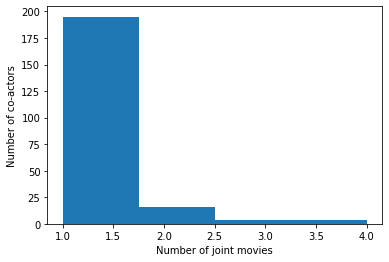

In [6]:
# histogram which presents the distribution of joint movies
import matplotlib.pyplot as plt
%matplotlib inline

# show histogram which presents the distribution of joint movies 
def show_histogram():
    bins = len(list(set(joint)))
    plt.hist(joint, bins = bins)
    plt.ylabel('Number of co-actors')
    plt.xlabel('Number of joint movies');
    
show_histogram()